<h1><center>Laboratorio 6: El Pandas no Muerde (act III) 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesores: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudantes: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Nicolás Becerra
- Nombre de alumno 2: Simón Sanfeliú


### **Link de repositorio de GitHub:** https://github.com/SimonSanfeliu/MDS7202-BS/tree/L6


## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Aplicar los paradigmas y buenas prácticas de programación vistas hasta este momento.
- Comprender y aprovechar las ventajas que nos ofrece la liberia `numpy` con respecto a trabajar en Python 'puro'.
- Visualizar aplicaciones de filtros de imágenes sin el uso de librerías.
- Verificar que el uso indiscriminado de `for` puede afectar en la eficiencia en al procesar datos masivos.


El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [3]:
%%capture
!pip install -r requirements.txt

In [4]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from scipy import stats

from IPython.display import display, Markdown, Latex

#Libreria para plotear
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px

In [5]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except: 
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin Mora quien es el gerente de una cotizada tienda de retail en Europa, les solicita si pueden analizar los datos de algunas de sus tiendas y si es posible extraer los diferenciar los tipos de clientes que posee el retail.

Para esto, el área de ventas les entrega el archivo `online_retail_II.xlsx` con el que se les pide que cargue y visualicen algunas de las filas que componen el Dataset.

Realice una primera visualización de los datos y señale los atributos que componen el dataset. Señale las columnas que conforman el dataset, el tipo de variable presente en cada columna y comente que representa cada una de estas.

**Respuesta:**

In [6]:
df_retail = pd.read_pickle("online_retail_II.pickle")
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": str,
        "Customer ID": "category",
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1.2 Análisis Explotatorio de los Datos [0.5 puntos] 

En base a la primera visualización del dataset, *Don Mora* le solicita que realicen un análisis exploratorio de los datos, para esto les deberán realizar un análisis univariado y multivariado. De la revisión, ustedes deben explicar potenciales anomalías visualizadas y señalar si existe la necesidad de realizar una limpieza de datos.

Explique a que nos referimos con análisis univariable, multivariable y de datos faltantes. ¿Qué beneficios nos otorga estudiar estos datos?. Sea conciso con su respuesta y no escriba mas de 5 líneas para su respuesta.

**Respuesta a la Pregunta:**

> El análisis univariable es analizar individualmente cada variable, viendo sus distribuciones, tendencias y valores atípicos. Sirve para estudiar de forma específica cada variable y saber más de estas. El análisis multivariable es analizar relaciones entre variables, usando gráficos de dispersión y otras técnicas para determinar dichas relaciones. Ayuda a encontrar correlaciones y ver cómo dependen entre sí las variables, pudiendo hacer un análisis más profundo. El análisis de datos faltantes es identificar los datos que faltan de la base de datos y decidir cómo manejarlos; lo que permite limpiar de forma adecuada el dataset y evitar sesgos en el análisis.

### 1.2.1 Análisis Univariado [2 Puntos]

A continuación, se le presentan dos funciones para analizar los datos que componen un dataframe. La primera de estas es la función ``profile_serie()`` la cual recibe una serie y le entrega un análisis detallado de los datos que conforman dicha serie. 

Ejecute la funcion ``profile_serie()`` sobre cada serie para realizar un análisis univariado de estas. A continuación, comente acerca de el comportamiento de cada variable según las estadísticas descriptivas y los gráficos generados.

In [7]:
from pandas.api.types import is_numeric_dtype
from pandas.core.dtypes.common import is_datetime_or_timedelta_dtype


def profile_serie(serie_in, n_samples=1000, random_state=42):
    serie = serie_in.copy()

    profile = pd.Series(dtype='object')
    profile["Type"] = serie.dtype
    profile = pd.concat([profile, serie.describe(datetime_is_numeric=True)])

    # profile = pd.Series([])

    if is_numeric_dtype(serie):
        profile["Negative"] = (serie < 0).sum()
        profile["Negative (%)"] = (
            str(round((serie < 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Zeros"] = (serie == 0).sum()
        profile["Zeros (%)"] = (
            str(round((serie == 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Kurt"] = serie.kurt()
        profile["Skew"] = serie.skew()

    profile[" "] = " "  # espacio

    profile["Missing cells"] = serie.isnull().sum()
    profile["Missing cells (%)"] = (
        str(round(serie.isnull().sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Duplicate rows"] = serie.duplicated(False).sum()
    profile["Duplicate rows (%)"] = (
        str(round(serie.duplicated(False).sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Total size in memory"] = str(serie.memory_usage(index=True)) + " bytes"

    # profile = pd.concat([profile, description])

    profile = profile.rename(
        index={
            "count": "Number of observations",
            "mean": "Mean",
            "std": "Std",
            "min": "Min",
            "max": "Max",
            "unique": "Unique",
            "top": "Top",
            "freq": "Freq",
        }
    )
    no_outliers_fig = None

    if is_numeric_dtype(serie):

        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(
            sampled_serie, marginal="box", title=f"{serie.name} - With Outliers"
        )

        no_outliers = sampled_serie.loc[(np.abs(stats.zscore(sampled_serie)) < 3)]
        # zscore = https://es.wikipedia.org/wiki/Unidad_tipificada
        
        no_outliers_fig = px.histogram(
            no_outliers, marginal="box", title=f"{serie.name} - Without Outliers"
        )

    elif is_datetime_or_timedelta_dtype(serie):
        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(sampled_serie, marginal="box", title=f"{serie.name}")
    
    else:
        count = (
            serie.value_counts()[0:100]
            .reset_index()
            .rename(columns = {serie.name: 'Count'})
        )
        fig = px.bar(
            x=count['index'].astype(str),
            y=count["Count"],
            title=f"100 Most common categories of {serie.name}",
        )
    display(Markdown(f'## {serie.name} Profile'))
    display(profile)
    fig.show()

    if no_outliers_fig:
        no_outliers_fig.show()

    # return fig, profile

In [8]:
profile_serie(df_retail['Price'])

## Price Profile

Type                            float64
Number of observations         525461.0
Mean                           4.688834
Std                          146.126914
Min                           -53594.36
25%                                1.25
50%                                 2.1
75%                                4.21
Max                            25111.09
Negative                              3
Negative (%)                      0.0 %
Zeros                              3687
Zeros (%)                         0.7 %
Kurt                       64868.344873
Skew                        -140.768446
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   524485
Duplicate rows (%)              99.81 %
Total size in memory      4203820 bytes
dtype: object

    Análisis de Price

Siendo una variable numérica, es más sencillo hacer un análisis estadístico de esta. En primera instancia, se puede ver que hay una gran cantidad de datos que están concentrados en la parte baja de precios, indicando que la mayoría de los productos son de bajo costo. Esto es aún más notorio al quitar los outliers, ya que estos últimos estaban muy por encima de la media (la media es de cerca de 5 dólares, mientras que el valor máximo era de ~21500). De esta forma, al quitar los outliers es posible tener una mejor visión de la distribución de los precios, viendo que posee, como es de esperarse en estas situaciones, una distribución similar a una exponencial.

Se tienen 3 valores negativos que no deberían existir, ya que estamos hablando de precios, pero al ver sus descripciones, podemos ver que son "Adjust bad debt". Esto quiere decir que son préstamos que se hicieron pero que no se devolverá el dinero, por lo que el dueño pierde dinero en dichos negocios. Así, se justifica su valor negativo.

Hay muchos productos cercanos a 0 en su valor, o que derechamente lo son (0.7% de los datos), por lo que serían gratis. Estos valores 0 lo más probable es que sean un error, dado que están asociados a cantidades negativas de su producto, por lo que no hay nada que vender, de ahí su valor. Estas cantidades negativas serán eliminadas más adelante, debido a que no aportan al análisis del dataset. Pero sí es normal tener productos de bajo precio dado el primer cuartil de la distribución y de que en general se venden productos pequeños sin mayor valor agregado.

Finalmente, es normal que haya muchos precios repetidos porque pueden ser los mismos productos, pero con distinto StockCode. Además, cabe mencionar que no hay datos faltantes.

In [9]:
profile_serie(df_retail["Quantity"])

## Quantity Profile

Type                              int64
Number of observations         525461.0
Mean                          10.337667
Std                           107.42411
Min                             -9600.0
25%                                 1.0
50%                                 3.0
75%                                10.0
Max                             19152.0
Negative                          12326
Negative (%)                     2.35 %
Zeros                                 0
Zeros (%)                         0.0 %
Kurt                        6277.666908
Skew                          36.044617
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   525122
Duplicate rows (%)              99.94 %
Total size in memory      4203820 bytes
dtype: object

    Análisis de Quantity

A diferencia del precio, existe un gran número de valores negativos en la cantidad de productos. Esto, debido a algunas descripciones de los productos, puede deberse a que se tienen encargos que superan el stock disponible o se pueden tratar también de devoluciones no bien registradas, aunque es necesario realizar un análisis más profundo o seguimiento para determinar la causa de estos valores negativos. Además, es importante mencionar que no faltan registros ni existen registros de cantidades nulas.

En cuanto a la distribución, tienden a concentrarse también en valores pequeños, aunque no tan concentrados como en el precio. Un cuarto de los pedidos es de más de 11 unidades de un mismo tipo de productos, por lo que se puede decir que la mayoría de los pedidos son en cantidades relativamente pequeñas. Esto es aún más notorio al quitar los outliers, ya que estos estaban muy por encima de la media (la media es de cerca de 10 unidades, mientras que el valor máximo era de ~19000). De esta forma, al quitar los outliers es posible tener una mejor visión de la distribución, concentrándose principalmente en el último cuartil. 

En resumen, se puede decir que la mayoría de los pedidos son de cantidades pequeñas, pero hay algunos que son de cantidades muy grandes, lo que puede indicar que existen clientes que requieren mucho de un mismo producto, o bien, que existe un producto que es muy requerido por los clientes, aunque esto último es menos probable y la tendencia apunta a que hay clientes que requieren pocas unidades de un mismo producto.

In [10]:
profile_serie(df_retail["InvoiceDate"])

## InvoiceDate Profile

Type                                     datetime64[ns]
Number of observations                           525461
Mean                      2010-06-28 11:37:36.845017856
Min                                 2009-12-01 07:45:00
25%                                 2010-03-21 12:20:00
50%                                 2010-07-06 09:51:00
75%                                 2010-10-15 12:45:00
Max                                 2010-12-09 20:01:00
                                                       
Missing cells                                         0
Missing cells (%)                                 0.0 %
Duplicate rows                                   520400
Duplicate rows (%)                              99.04 %
Total size in memory                      4203820 bytes
dtype: object

    Análisis de InvoiceDate

A diferencia de los análisis anteriores, InvoiceDate (fecha de factura) es una variable categórica, por lo que no se puede realizar un análisis de tendencia o distribución y, al estar en un rango similar a un año, solo es posible definir el comportamiento mes a mes y comparar entre ellos. La existencia de tantas filas duplicadas se explica debido a que las filas no son facturas separadas, sino el detalle de una misma factura, por ende, se repite la fecha de la factura por cada detalle. Por otro lado, es bueno que no haya datos faltantes, ya que se puede analizar de forma completa.

Al analizar el gráfico de esta muestra, se puede ver que los meses de mayor venta son los de noviembre y diciembre, lo cual es esperable debido a las fiestas de fin de año. Aprovechar esta instancia puede beneficiar las ventas de la empresa. De la misma forma, los meses de julio y enero presentan una baja frecuencia en comparación al resto, por lo que también es posible aprovechar estas fechas para ajustar la estrategia de ventas.

In [11]:
profile_serie(df_retail["Country"])

## Country Profile

Type                              object
Number of observations            525461
Unique                                40
Top                       United Kingdom
Freq                              485852
                                        
Missing cells                          0
Missing cells (%)                  0.0 %
Duplicate rows                    525461
Duplicate rows (%)               100.0 %
Total size in memory       4203820 bytes
dtype: object

    Análisis de Country

Como el país es un string, el único análisis estadístico que se puede hacer es la frecuencia de cada uno. Viendo los datos, se puede asumir que estos países se refieren a desde dónde se están comprando los productos, teniendo que la mayoría de dichas compras son del Reino Unido. Esto hace sentido, puesto que al revisar con detención los datos y sus descripciones, es posible ver que la tienda es originaria de este mismo país, por lo que es esperable que la mayoría de su clientela sea de este mismo. De hecho, esto se da de forma muy evidente, ya que, de los más de 500 mil datos, cerca de 490 mil son provenientes del Reino Unido. Esto se vuelve a confirmar al ver el segundo país con más compras: Irlanda (escrito en irlandés como Éire).

Se puede ver también que no hay datos faltantes y que, como es de esperarse, que todas las filas sean duplicadas de alguna ya que se tienen compras de un mismo país en repetidas ocasiones. Asimismo, es relevante mencionar la gran variedad de países que se tienen, pudiendo ver un gran alcance de la tienda (aunque sea en cantidades pequeñas en comparación al Reino Unido).

In [12]:
profile_serie(df_retail["Invoice"])

## Invoice Profile

Type                           category
Number of observations           525461
Unique                            28816
Top                              537434
Freq                                675
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   517456
Duplicate rows (%)              98.48 %
Total size in memory      2338390 bytes
dtype: object

    Análisis de Invoice

Al igual que InvoiceDate, los duplicados se deben a que Invoice corresponde a una misma factura, por lo que se repite el número de factura por cada detalle separado en distintas filas según los productos de cada compra. Nuevamente, no hay datos faltantes, por lo que se puede analizar de forma completa y se reconoce como un buen registro por parte de la compañía.

Por sí solo, Invoice no entrega información relevante, ya que sólo es un identificador de la factura, por lo que no se puede analizar de forma individual. Sin embargo, es posible extraer información relevante al analizar junto con otros valores, como InvoiceDate, para analizar el comportamiento de las ventas mes a mes, o con StockCode, para analizar el comportamiento de las ventas de un producto en específico. Sin embargo, esta información muestra un gran número de facturas donde se compran más de 200 tipos de productos distintos, lo cual muestra la tendencia de los clientes a realizar compras de varios productos a la vez. Por ejemplo, la factura 537434, es la que más se repite, con una frecuencia de 675. Esto implica que la factura contiene 675 tipos de productos (StockCode), teniendo que la cantidad de dichos productos irá variando aún más.

In [13]:
profile_serie(df_retail["StockCode"])

## StockCode Profile

Type                           category
Number of observations           525461
Unique                             4632
Top                              85123A
Freq                               3516
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   525026
Duplicate rows (%)              99.92 %
Total size in memory      1220246 bytes
dtype: object

    Análisis de StockCode

Esta variable se hizo categórica para poder trabajar los códigos de los productos (StockCode) de manera más sencilla, ya que no es necesario un análisis estadístico de estos, sólo su frecuencia. Así, es posible ver qué productos son los más demandados, por lo que con esto se puede generar una estrategia financiera para poder priorizar estos en la línea productiva. 

Dado que se tienen varios productos, es esperable que no todas las filas sean duplicadas, pero sí la mayoría ya que habrán productos más populares que se pedirán varias veces. No hay datos faltantes, por lo que se simplifica el análisis y el producto más popular por lejos es aquel con el código 85123A. Cabe mencionar que los códigos a los que se les agregan letras al final corresponden al mismo producto, pero que por stock debieron asignarle un nuevo código. Luego, no hay una relación 1 a 1 entre StockCode y producto.

Este análisis se puede reforzar al ver el análisis de las cantidades, ya que puede resultar necesario reforzar el stock de aquellos códigos con cantidades muy negativas.

In [14]:
profile_serie(df_retail["Description"])

## Description Profile

Type                                                  object
Number of observations                                525461
Unique                                                  4682
Top                       WHITE HANGING HEART T-LIGHT HOLDER
Freq                                                    3549
                                                            
Missing cells                                              0
Missing cells (%)                                      0.0 %
Duplicate rows                                        525198
Duplicate rows (%)                                   99.95 %
Total size in memory                           4203820 bytes
dtype: object

    Análisis de Description

Esta variable consiste en la descripción de cada producto, además de describir casos problemáticos, como los préstamos no pagados o incluso errores en el dataset (hay valores con sólo signos de interrogación). Es por esto por lo que tiene una mayor cantidad de valores únicos que StockCode, aunque sean sólo 50 más. Siguiendo esto, se tiene que no faltan datos, por lo que se puede hacer un análisis sin problemas; además de que es esperable que los datos se repitan al comprar un producto varias veces.

Como casi todas las descripciones están asociadas a productos, es esperable que aquella con mayor frecuencia corresponda a la descripción del producto (StockCode) más comprado. De esta forma, se tiene que WHITE HANGING HEART T-LIGHT HOLDER es la descripción más mencionada, con 3549; lo que presenta un desfase con el producto 85123A de 43, pero estos otros productos están en el código 85123B, que sería la continuación de este mismo. Así, se tiene que efectivamente la descripción denota de forma única a los productos.

In [15]:
profile_serie(df_retail["Customer ID"])

## Customer ID Profile

Type                           category
Number of observations         417534.0
Unique                           4383.0
Top                             14911.0
Freq                             5710.0
                                       
Missing cells                    107927
Missing cells (%)               20.54 %
Duplicate rows                   525327
Duplicate rows (%)              99.97 %
Total size in memory      1218254 bytes
dtype: object

    Análisis de Customer ID

Dada la naturaleza de la variable bajo el contexto que está, es esperable que hayan múltiples valores únicos y, debido al formato del registro, aún más duplicados, dado que un mismo cliente puede realizar múltiples compras de varios productos a la vez, lo que explica la gran densidad de duplicados (99.97%).

Es necesario destacar que existe una gran cantidad de registros sin ID de cliente, lo que se puede deber a escenarios como ajustes de deudas, devoluciones, restock, etc. Sin embargo, se requiere de un análisis más profundo y detallado para develar el verdadero motivo, o incluso un seguimiento hacia atrás.

El comportamiento de los clientes es muy variado, por lo que es necesario realizar un análisis más profundo para poder determinar el comportamiento de los clientes y así poder generar estrategias de venta más efectivas. No obstante, se puede ver que hay clientes que compran mucho y otros que compran poco, por lo que se puede generar una estrategia de fidelización de clientes para los que compran más, y una estrategia de captación de clientes para los que compran poco.

### 1.2.2 Análisis Multivariado y Datos Faltantes [1 ptos]

En segundo lugar encontrará la función ``profile_df()`` que recibe un dataframe como entrada y realiza un análisis bivariado de todas las variables numéricas que conforman el dataframe, un analisis de la correlación de Pearson entre las variables numericas del dataframe y la matriz de datos faltantes. Ejecute la función `profile_df` y comente sus resultados.

In [16]:
def profile_df(dataframe_in):
    df = dataframe_in.copy()

    list_type = []
    for col in list(df.columns):
        if is_numeric_dtype(df[col]) or \
        pd.core.dtypes.common.is_datetime_or_timedelta_dtype(df[col]):
            list_type.append(col)

    
    display(Markdown('## Bivariant Analysis:'))
    for i in range(len(list_type)):
        for j in range(i+1, len(list_type)):
            plt.scatter(df[list_type[i]], df[list_type[j]])
            plt.xlabel(list_type[i]) 
            plt.ylabel(list_type[j]) 
            plt.title(f"{list_type[i]} v/s {list_type[j]}")
            plt.show()

    display(Markdown('## Correlation:'))
    fig_corr = px.imshow(df[list_type].corr())
    fig_corr.show()

    display(Markdown('## Missing Matrix:'))
    fig, ax = plt.subplots(figsize=[15, 10])
    msno.matrix(df, ax=ax, sparkline=False)

## Bivariant Analysis:

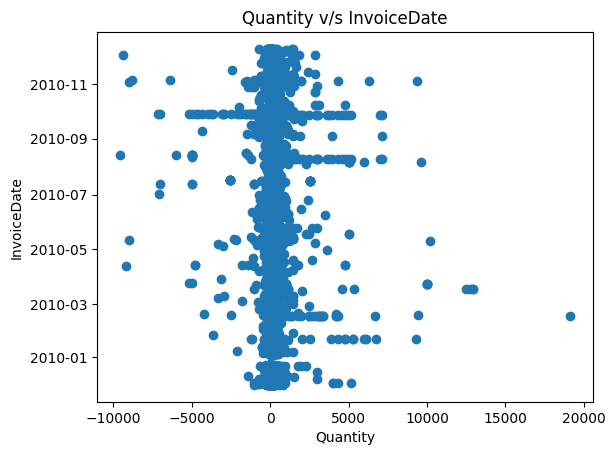

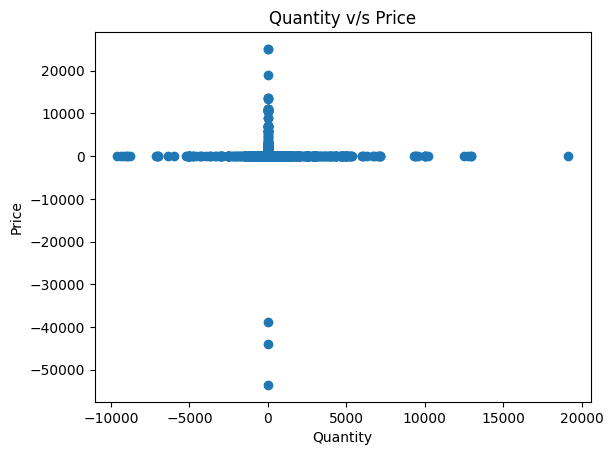

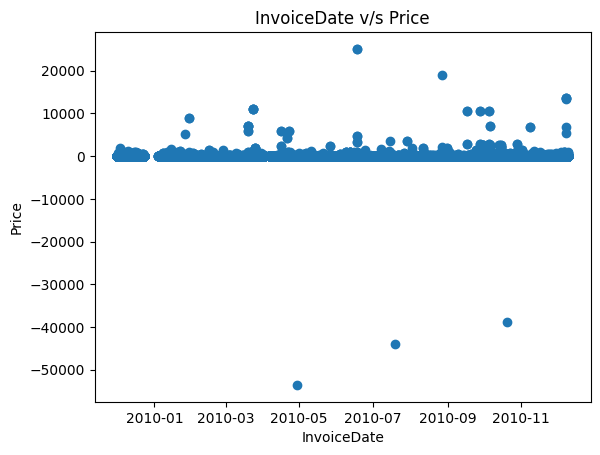

## Correlation:

C:\Users\franc_eeov2k1\AppData\Local\Temp\ipykernel_1404\2390459975.py:21: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Missing Matrix:

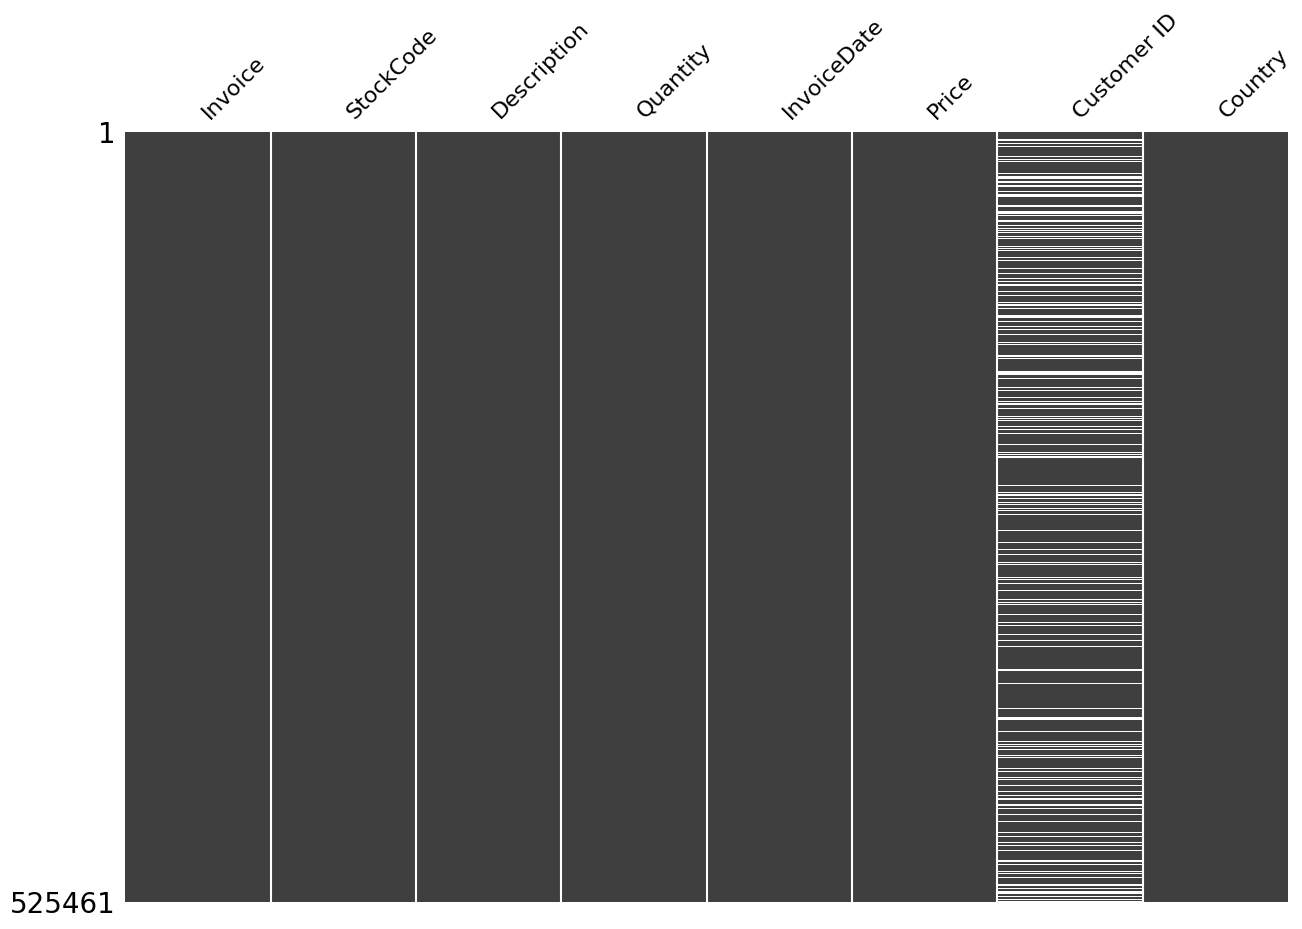

In [17]:
profile_df(df_retail)

    Análisis Multivariado

Primeramente, se aprecia una clara tendencia a acumularse las compras según fecha de factura en cantidades pequeñas, lo que se puede deber a que la mayoría de los clientes compran pocas unidades de un mismo producto, como se vio en el análisis univariado de Quantity. De todas formas, es importante destacar otro tipo de comportamientos como las fechas cercanas octubre donde existen muchos registros de cantidades altas, tanto negativas como positivas, lo cual puede ser objeto de estudio para determinar la causa de este comportamiento. Fuera de eso, se vuelve a notar una gruesa acumulación de puntos en fechas cercanas a navidad y año nuevo. También es posible visualizar las fechas donde existen compras con mayor variedad y cantidad de productos, que se muestran como líneas horizontales con acumulación de puntos, las cuales se aprecian claramente al menos 4 casos.

Para el caso de cantidad vs precio, se presenta una distribución bien definida en forma de cruz, concentrándose en cantidades entre [-5000, 5000] y precios positivos menores a $10000. Esto se puede deber a que la mayoría de los productos son de bajo costo, como se vio en el análisis univariado de Price. Además, se puede ver que hay una gran cantidad de productos con cantidades negativas y precios nulos, cuyos ID de cliente son nulos, por lo que se entienden como ajustes de stock, devoluciones o unidades dadas de baja por daños o pérdidas, según la descripción de estos (df_retail[df_retail["Quantity"] < 0][df_retail["Price"] == 0]["Description"].unique()). Por ende, es necesario limpiar los datos antes de evaluar un comportamiento netamente de los clientes.

Con respecto a "InvoiceDate vs Price", el gráfico permite apreciar un período sin registros disponibles cercanos a enero de 2010, lo cual resulta llamativo a primera vista, pero no se le dará mayor importancia por ahora. Fuera de eso, se puede ver que la mayoría de los registros se concentran en precios menores a precios relativamente bajos, lo cual se puede deber a que la mayoría de los productos son de bajo costo, como se vio en el análisis univariado de Price. Los ajustes de mala deuda también se aprecian periódicamente. En cuanto a los clientes, es posible apreciar contables momentos donde se registran compras de precios altos, siguiendo cierta periodicidad, lo cual puede ser objeto de estudio para determinar la causa de este comportamiento. Por otro lado, se vuelve a notar una gruesa acumulación de puntos a fines del periodo registrado, aunque también existen puntos de altos precios entre marzo y mayo.

Ahora describiendo la matriz de correlación entre precio y cantidad, desde el gráfico anterior existe una falta de relación entre variables, dado que se apreciaba una distribución en forma de cruz. Esto se confirma al ver la matriz de correlación, donde se aprecia una correlación de 0.07, lo cual es muy cercano a 0, por lo que se puede decir que no existe una relación entre estas variables. Esto, sin embargo, se debe también a los diferentes casos donde no se expresa adecuadamente el comportamiento del cliente en los registros, por lo que no resulta fidedigno de estudio, aunque sí muestra la necesidad de limpiar el dataset.

Finalmente, se puede ver que no hay datos faltantes en las variables numéricas, por lo que se pudo analizar de forma completa. Sin embargo, los registros de ID de cliente presentan muchas filas nulas, lo que se puede deber a que son ajustes de stock, devoluciones, restock, etc, por lo que se espera que luego de la limpieza dejen de estar presentes dichas ausencias de registros.

### 1.2.3 Limpieza de Datos [1 pto]

Como pudo ver en las secciones anteriores, los datos presentan valores erroneos, es por esto que se le solicita que genere una función que permita limpiar el dataset. Realice esta función en base observaciones propias y considere como imposible tener cantidades negativas en las ventas.

Una vez realizada la función, realice nuevamente el análisis exploratorio y comente las principales diferencias.

**Respuesta:**

Al explorar en mayor detalle el dataframe, se pudo encontrar que cerca de 12 mil datos presentan cantidades negativas. En particular, los datos más problemáticos, con precio 0 e ID de comprador nulos, todos presentaban cantidades negativas. Junto con esto, todas sus descripciones equivalían a fallas técnicas, devoluciones o quejas; por lo que no aportan al momento de obtener las ganancias del negocio. De esta forma, estos debían eliminarse de forma definitiva. 

Los otros casos vistos, en que el precio fuera positivo (el precio negativo equivale a préstamos no pagados, por lo que se mantienen como forma de análisis financiero viéndolos como pérdidas) y/o el ID del comprador fuera no nulo, pueden representar tanto devoluciones como errores al rellenar el dataset. Así, pensando en que las ganancias se obtendrán sólo considerando el flujo de entrada de dinero y no una salida de éste de forma marginal con los 8 mil datos de 500 mil que podrían ser considerados como datos de "devoluciones" (de nuevo, no estamos seguros de ello).

De esta forma, para trabajar de forma más sencilla y sin confusiones por supuestas devoluciones o errores en el dataset, se decidió trabajar sólo con los datos cuyas cantidades fueran positivas. Esto incluye datos en que el ID del comprador es nulo, pero para efectos del estudio que se quiere hacer, esto no es relevante, ya que nos interesa que el resto de las columnas sean no nulas.

In [18]:
# Limpieza de datos
df_retail = df_retail[df_retail["Quantity"] >= 0]

df_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [19]:
profile_serie(df_retail["Quantity"])

## Quantity Profile

Type                              int64
Number of observations         513135.0
Mean                          11.715412
Std                           92.974635
Min                                 1.0
25%                                 1.0
50%                                 3.0
75%                                10.0
Max                             19152.0
Negative                              0
Negative (%)                      0.0 %
Zeros                                 0
Zeros (%)                         0.0 %
Kurt                        9645.604332
Skew                          80.348041
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   512971
Duplicate rows (%)              99.97 %
Total size in memory      8210160 bytes
dtype: object

In [53]:
profile_serie(df_retail["Price"])

## Price Profile

Type                            float64
Number of observations         513135.0
Mean                           3.973446
Std                          127.952849
Min                           -53594.36
25%                                1.25
50%                                 2.1
75%                                4.21
Max                            25111.09
Negative                              3
Negative (%)                      0.0 %
Zeros                              1566
Zeros (%)                        0.31 %
Kurt                      107801.775551
Skew                        -251.734234
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   512276
Duplicate rows (%)              99.83 %
Total size in memory      8210160 bytes
dtype: object

In [62]:
profile_serie(df_retail["Invoice"])

## Invoice Profile

Type                           category
Number of observations           513135
Unique                            22104
Top                              537434
Freq                                675
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   509886
Duplicate rows (%)              99.37 %
Total size in memory      6418686 bytes
dtype: object

In [63]:
profile_serie(df_retail["Description"])

## Description Profile

Type                                                  object
Number of observations                                513135
Unique                                                  4561
Top                       WHITE HANGING HEART T-LIGHT HOLDER
Freq                                                    3456
                                                            
Missing cells                                              0
Missing cells (%)                                      0.0 %
Duplicate rows                                        512945
Duplicate rows (%)                                   99.96 %
Total size in memory                           8210160 bytes
dtype: object

In [57]:
profile_serie(df_retail["InvoiceDate"])

## InvoiceDate Profile

Type                                     datetime64[ns]
Number of observations                           513135
Mean                      2010-06-28 21:19:37.542167296
Min                                 2009-12-01 07:45:00
25%                                 2010-03-21 15:03:00
50%                                 2010-07-06 16:26:00
75%                                 2010-10-15 14:51:00
Max                                 2010-12-09 20:01:00
                                                       
Missing cells                                         0
Missing cells (%)                                 0.0 %
Duplicate rows                                   510885
Duplicate rows (%)                              99.56 %
Total size in memory                      8210160 bytes
dtype: object

In [58]:
profile_serie(df_retail["Country"])

## Country Profile

Type                              object
Number of observations            513135
Unique                                40
Top                       United Kingdom
Freq                              474938
                                        
Missing cells                          0
Missing cells (%)                  0.0 %
Duplicate rows                    513135
Duplicate rows (%)               100.0 %
Total size in memory       8210160 bytes
dtype: object

In [54]:
profile_serie(df_retail["Customer ID"])

## Customer ID Profile

Type                           category
Number of observations         407695.0
Unique                           4314.0
Top                             14911.0
Freq                             5570.0
                                       
Missing cells                    105440
Missing cells (%)               20.55 %
Duplicate rows                   513042
Duplicate rows (%)              99.98 %
Total size in memory      5298550 bytes
dtype: object

In [55]:
profile_serie(df_retail["StockCode"])

## StockCode Profile

Type                           category
Number of observations           513135
Unique                             4317
Top                              85123A
Freq                               3422
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   512932
Duplicate rows (%)              99.96 %
Total size in memory      5300542 bytes
dtype: object

Del análisis univariable de cada variable, se ve que las columnas Customer ID, Description, Country, Invoice, InvoiceDate, StockCode y Price mantienen las cualidades mencionadas en la parte 1.2.1, salvo por la pérdida de algunos de sus datos. La variable que más cambió fue, como era de esperarse, Quantity, teniendo ahora una distribución principalmente concentrada en valores pequeños, con muchos menos outliers y más similar a una exponencial muy concentrada cerca del 0.

## Bivariant Analysis:

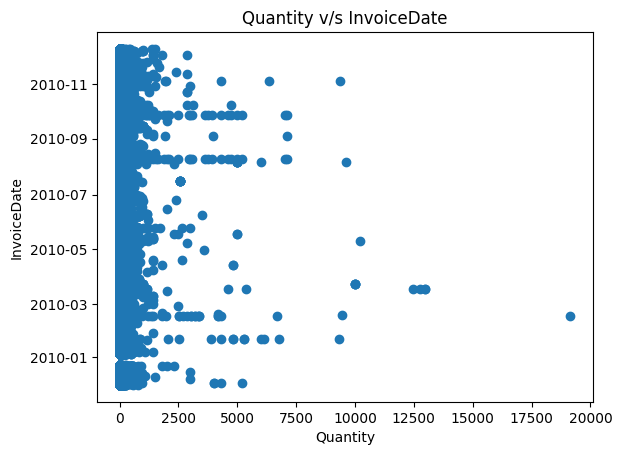

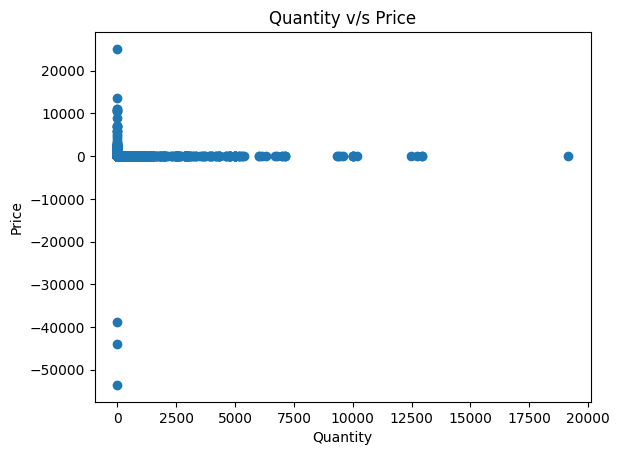

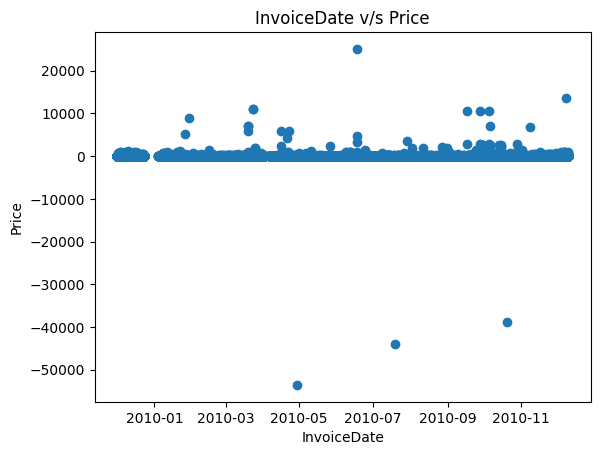

## Correlation:

C:\Users\franc_eeov2k1\AppData\Local\Temp\ipykernel_1404\2390459975.py:21: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Missing Matrix:

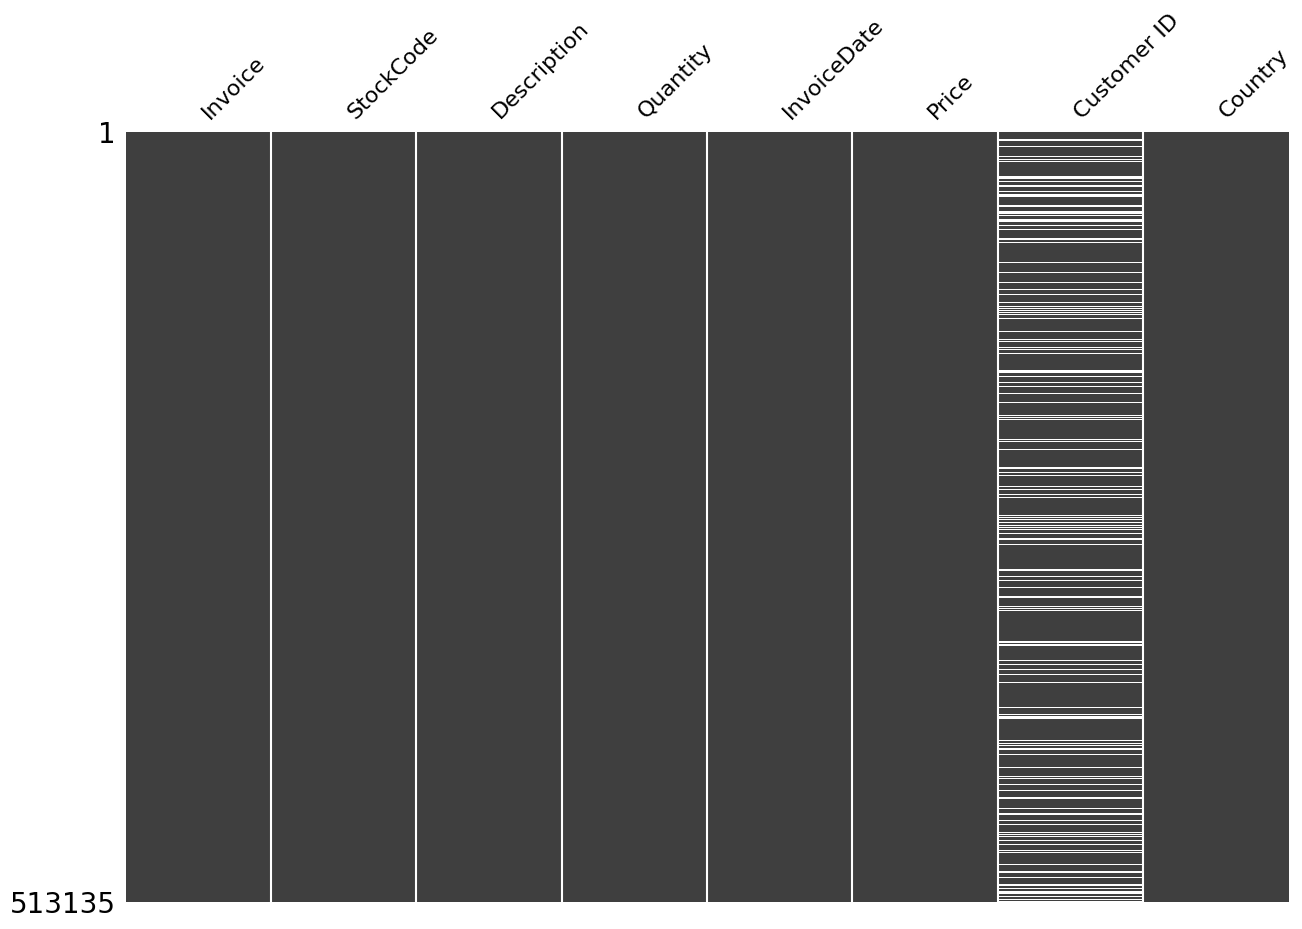

In [20]:
profile_df(df_retail)

El análisis multivariado no se modifica mucho, aunque luego de la eliminación de las cantidades negativas, se aprecian mejor las tendencias ya mencionadas. Sin embargo, resulta importante destacar que la correlación no presentó mejoras significativas en comparación a la matriz de correlación anterior, por lo que se puede decir que no existe una relación entre las variables numéricas, al menos por como está redactado el dataset. Aún existen muchos valores duplicados sobre todo en las variables categóricas, pero no es posible eliminarlos ya que son parte de la naturaleza del dataset. Con esto, sería necesario hacer una agregación segmentada, ya sea entre compras de un mismo cliente, compras de un mismo producto, compras de un mismo país, etc. Esto, para poder hacer un análisis más profundo y detallado de los datos.

Se destaca que se decidió no eliminar los registros donde no se tenía ID del cliente, ya que, si bien se puede asumir que son devoluciones, no se tiene certeza de ello, por lo que se decidió mantenerlos para no perder información. Además, se puede ver que no hay datos faltantes en las variables numéricas, por lo que se pudo analizar de forma completa. Sin embargo, los registros de ID de cliente presentan muchas filas nulas, lo que puede provocar un análisis sesgado o poco fidedigno con el comportamiento del cliente. De todas formas, se insiste en preservar la información para develar otros posibles eventos.

### 1.2.4 Obtención de TOPs [0.75 ptos]

Sin considerar los comentarios realizados en la sección 1.2 , *Don Mora* les pide obtener el **Top de 30 productos que generan más ganancias** para la tienda de retail. Deben considerar todo el registro temporal presente en el dataset y entregar la información en un gráfico de barras de los ingresos/cantidades v/s el nombre de los productos (Utilice `plotly`). ¿Los artículos más vendidos son los mismos que generan más ganancias?, Comente los resultados obtenidos.

**Resultados:**

In [21]:
df_retail["Income"] = df_retail["Price"] * df_retail["Quantity"]
top30 = df_retail.groupby(["Description"]).sum().sort_values(by="Income", ascending=False)[:30]
top30

C:\Users\franc_eeov2k1\AppData\Local\Temp\ipykernel_1404\157058076.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Quantity,Price,Income
Description,,,
Manual,2832,260897.18,262992.08
REGENCY CAKESTAND 3 TIER,13704,29374.30,170078.51
WHITE HANGING HEART T-LIGHT HOLDER,58793,10640.38,160630.78
DOTCOM POSTAGE,733,116408.71,116408.71
ASSORTED COLOUR BIRD ORNAMENT,45356,2887.66,73092.99
PAPER CHAIN KIT 50'S CHRISTMAS,17226,3354.59,58189.25
JUMBO BAG RED RETROSPOT,30807,2841.37,56595.51
PARTY BUNTING,10096,5797.18,49682.72
POSTAGE,2310,20231.29,49477.54


In [22]:
fig = px.bar(
            x=top30.index.astype(str),
            y=top30["Income"],
            title=f"30 productos que generan más ganancias",
        )
fig.show()

De los resultados obtenidos, es posible ver que Manual es el que más ganancias genera, pero esto debido principalmente a su variado precio, ya que en general se registran valores bajos o muy altos de este considerando que el segundo que genera más ingresos vende cerca de 6 veces la cantidad que vende Manual. Esto hace sentido, puesto que, teniendo también en consideración la distribución de precios vista en la parte 1.2.1, se sabe que la mayoría de los productos poseen bajos precios y que deben venderse en grandes cantidades para generar ingreso considerable; pero el mismo efecto puede obtenerse con suficientes compras de aquellos precios que en los bordes de la distribución o bien que sean outliers. Luego, con registros tan variados, es posible generar más ingresos al registrar manualmente productos que tengan un precio alto y que se vendan en pocas cantidades, que con un producto que tenga un precio bajo y que se venda en grandes cantidades.

In [23]:
df_retail[df_retail["Description"] == "Manual"].Price.describe()

count      561.000000
mean       465.057362
std       1712.826117
min          0.000000
25%          0.850000
50%          3.750000
75%        176.960000
max      25111.090000
Name: Price, dtype: float64

Como se aprecia en la celda anterior, si bien la mitad de los ingresos manuales van entre 0 y 3.75, la otra mitad varía mucho más, siendo tan solo el último cuartil el que posee un rango entre 177 y 25111 en precio. Con esto en mente, las cantidades de registros no deben ser necesariamente mayores para poder sobrepasar las ventas de otro tipo de producto. Lamentablemente, no se cuenta con más antecedentes de este tipo de ingresos, por lo que motivos de la distribución de dichos datos no puedes ser ahondados.

In [24]:
df_retail[df_retail["Description"] == "REGENCY CAKESTAND 3 TIER"].Price.describe()

count    2046.00000
mean       14.35694
std         4.70847
min         0.00000
25%        12.75000
50%        12.75000
75%        12.75000
max        29.95000
Name: Price, dtype: float64

Viendo ahora el segundo producto que más ganancias genera, se nota que éste tiene una distribución de precios mucho más concentrada y que además se vende mucho más que Manual. Esto vuelve a confirmar lo establecido en un principio: no necesariamente por venderse más generará más ganancias, el precio es un factor importante para definir estos valores.

### 1.2.5 Visualización del registro temporal [0,75 ptos]

El dueño del retail en su afán por saber más sobre los datos de su firma les solicita que grafiquen las ventas respecto al tiempo. Con esto les aclara que durante el día tienen muchas variaciones en sus ventas, por lo que les recomienda que consideren el registro temporal como `año-mes-día`. ¿Es posible observar datos extraños?, Comente lo que observa del gráfico.

In [80]:
def plot_ventas(dataframe):
    df_copy = dataframe.copy()

    #Escribimos las fechas sin considerar la hora
    df_copy["InvoiceDate"] = df_copy["InvoiceDate"].dt.date

    #Agrupamos por fecha y sumamos las ventas
    df_copy = df_copy.groupby(["InvoiceDate"]).sum().sort_values(by="InvoiceDate", ascending=False)

    #Graficamos
    fig = px.bar(
            x=df_copy.index.astype(str),
            y=df_copy["Income"],
            title=f"Ventas por día"
        ).update_yaxes(title_text='Ventas ($)', tickprefix="$").update_xaxes(title_text='Fecha (día)')
    
    fig.show()

plot_ventas(df_retail)

C:\Users\franc_eeov2k1\AppData\Local\Temp\ipykernel_1404\3823888105.py:8: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Dentro de las observaciones interesantes, cabe destacar que hay dos períodos marcados en el gráfico donde no existen registros, uno de ellos es el período de navidad y año nuevo del 2009 y el otro es durante semana santa aproximadamente. Resulta lógico considerar que no existen registros en estos ya que son festividades importantes y usualmente no laborales. Sin embargo, en 2010 si se anotaron registros durante esas fechas, por lo que se puede pensar que hubo alguna automatización o un registro hacia atrás. Fuera de eso, también resulta interesante la separación cada 6 días a modo general, lo que indica que se trabajan durante 6 días a la semana. En cuanto a puntos importantes, existen muchos peaks altos en ventas durante los últimos meses del año, pero el mayor peak se produce el 27 de septiembre de 2011, lo cual resulta llamativo y sería interesante indagar sobre los motivos de esta fecha en particular. En general, las ventas se mantienen en un rango de 10000 a 20000, pero existen una cantidad no menor de peaks que superan los 50000, y también se aprecia una especie de periodicidad de altas y bajas de ventas sobre todo entre los meses de ventas de menor rango, por lo que es posible establecer una predicción semana a semana de acuerdo con los patrones que se aprecian en el gráfico si se deseara. Con esto, nos referimos a mini periodos donde la venta asciende y luego descienden. Esto se puede explicar con el factor de reabastecimiento periódico que pueden necesitar los clientes. Con respecto a los valores negativos, se recuerda que estos corresponden a ajustes de mala deuda que deben ir en los registros de stock y venta por motivos legales y notariales, por lo que se descartan para el análisis del cliente, pero no para el análisis financiero.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>